# Лабораторная работа 4

Датасет - **Цены на бриллианты**	https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices

1. **carat**: Вес бриллианта в каратах
2. **cut**: Качество огранки.
3. **color**: Цвет бриллианта
4. **clarity**: Чистота бриллианта
5. **depth**: Процент глубины бриллианта
6. **table**: Процент ширины бриллианта
7. **price**: Цена бриллианта в долларах США
8. **x**: Длина бриллианта в миллиметрах
9. **y**: Ширина бриллианта в миллиметрах
10. **z**: Глубина бриллианта в миллиметрах

**Бизнес-цели**: 
1. Прогнозирование цены бриллиантов на основании характеристик.
2. Анализ частотности и сочетания характеристик бриллиантов, которые пользуются наибольшим спросом, чтобы лучше планировать запасы. 

#### Загрузка набора данных

In [24]:
import pandas as pd

from sklearn import set_config

set_config(transform_output="pandas")

df = pd.read_csv("data/Diamonds.csv", index_col="id")

random_state=42
#считаем средний вес бриллиантов
average_carat = df['carat'].mean()

print(f"Среднее значение поля 'карат': {average_carat}")

#новый столбец, в котором 1 значит больше ср знач, 0 меньше
average_carat = df['carat'].mean()
df['above_average_carat'] = (df['carat'] > average_carat).astype(int)
df

Среднее значение поля 'карат': 0.7979346717831785


carat        cut color clarity  depth  table  price     x     y     z  \
id                                                                             
1       0.23      Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43   
2       0.21    Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31   
3       0.23       Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31   
4       0.29    Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63   
5       0.31       Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75   
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...   
53939   0.86    Premium     H     SI2   61.0   58.0   2757  6.15  6.12  3.74   
53940   0.75      Ideal     D     SI2   62.2   55.0   2757  5.83  5.87  3.64   
53941   0.71    Premium     E     SI1   60.5   55.0   2756  5.79  5.74  3.49   
53942   0.71    Premium     F     SI1   59.8   62.0   2756  5.74  5.73  3.43   
53943   0.70  Very Good     E     VS2   60.5   59.0   2757  5.71  5.76  3.47   

       above_average_carat  
id                          
1                        0  
2                        0  
3                        0  
4                        0  
5                        0  
...                    ...  
53939                    1  
53940                    0  
53941                    0  
53942                    0  
53943                    0  

[53943 rows x 11 columns]

#### Разделение набора данных на обучающую и тестовые выборки (80/20) для задачи классификации

Целевой признак -- Cut

In [34]:
from typing import Tuple
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.
    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().
    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input  # содержит все столбцы.
    y = df_input[
        [stratify_colname]
    ]  # содержит столбец для стратификации.
    X = df.drop(['above_average_carat'], axis=1)
    y = df['above_average_carat']
    # Первичное разбиение на обучающую и временную выборки.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )
    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    # Вторичное разбиение на валидационную и тестовую выборки.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

#разбиение на 80% обучающей выборки и 20% тестовой выборки
#Стратификация выполняется по столбцу "above_average_carat"
X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="above_average_carat", frac_train=0.80, frac_val=0, frac_test=0.20, random_state=random_state
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

carat        cut color clarity  depth  table  price     x     y     z
id                                                                          
38836   0.40  Very Good     F    VVS2   62.0   56.0   1049  4.71  4.74  2.93
30260   0.40  Very Good     E     SI1   63.0   57.0    725  4.68  4.71  2.96
33169   0.36      Ideal     E     VS1   61.8   56.0    817  4.55  4.58  2.82
1029    0.70  Very Good     E     VS1   58.4   59.0   2904  5.83  5.91  3.43
53809   0.81  Very Good     G     SI1   60.7   56.0   2733  6.06  6.09  3.69
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
2937    0.77       Good     E     VS2   63.4   57.0   3291  5.80  5.84  3.69
7514    0.90       Good     F     SI1   61.8   63.0   4241  6.21  6.18  3.83
48344   0.56      Ideal     H    VVS1   62.1   53.8   1961  5.27  5.33  3.29
3212    0.70    Premium     F    VVS1   61.8   60.0   3348  5.67  5.63  3.49
35654   0.31  Very Good     G    VVS2   63.1   57.0    907  4.32  4.30  2.72

[43154 rows x 10 columns]

'y_train'

id
38836    0
30260    0
33169    0
1029     0
53809    1
        ..
2937     0
7514     1
48344    0
3212     0
35654    0
Name: above_average_carat, Length: 43154, dtype: int64

'X_test'

carat        cut color clarity  depth  table  price     x     y     z
id                                                                          
32452   0.39  Very Good     E     VS2   60.9   58.0    793  4.72  4.77  2.89
2432    0.72  Very Good     E     SI1   63.3   56.0   3183  5.67  5.71  3.60
16456   1.21      Ideal     H     SI1   62.1   59.0   6573  6.81  6.75  4.21
46045   0.56      Ideal     D     SI1   62.5   56.0   1729  5.28  5.24  3.29
11115   1.00       Good     E     SI1   62.4   59.0   4936  6.35  6.40  3.98
...      ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
40250   0.50    Premium     F     SI1   59.6   61.0   1125  5.15  5.12  3.06
3308    0.73      Ideal     E     VS1   62.3   56.0   3370  5.75  5.80  3.60
7894    1.12  Very Good     I     SI1   60.6   60.0   4312  6.73  6.77  4.09
21368   0.36      Ideal     D     SI1   62.2   53.0    626  4.57  4.59  2.85
46144   0.50    Premium     E     VS2   61.3   59.0   1746  5.10  5.05  3.11

[10789 rows x 10 columns]

'y_test'

id
32452    0
2432     0
16456    1
46045    0
11115    1
        ..
40250    0
3308     0
7894     1
21368    0
46144    0
Name: above_average_carat, Length: 10789, dtype: int64

#### Формирование конвейера для классификации данных

preprocessing_num -- конвейер для обработки числовых данных: заполнение пропущенных значений и стандартизация

preprocessing_cat -- конвейер для обработки категориальных данных: заполнение пропущенных данных и унитарное кодирование

features_preprocessing -- трансформер для предобработки признаков

features_engineering -- трансформер для конструирования признаков

drop_columns -- трансформер для удаления колонок

pipeline_end -- основной конвейер предобработки данных и конструирования признаков

In [40]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

class DaimondFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    #добавляем новый столбец "Length_to_Width_Ratio" - отношение длины к ширине (столбцы x и y)
    def transform(self, X, y=None):
        X["Length_to_Width_Ratio"] = X["x"] / X["y"]
        return X
    #добавляем имя нового столбца к входным именам
    def get_feature_names_out(self, features_in):
        return np.append(features_in, ["Length_to_Width_Ratio"], axis=0)
    
#Список столбцов, которые будут удалены из данных
columns_to_drop = []
#Список числовых столбцов
num_columns = ["carat", "depth", "table", "x", "y", "z"]
#Список категориальных столбцов
cat_columns = ["cut", "color", "clarity"]

#Предобработка числовых столбцов
#Используется для заполнения пропущенных значений в числовых столбцах медианой
num_imputer = SimpleImputer(strategy="median")
#Стандартизирует числовые столбцы, приводя их к нулевому среднему и единичному стандартному отклонению
num_scaler = StandardScaler()
#Создается конвейер для последовательного применения SimpleImputer и StandardScaler
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)
#Предобработка категориальных столбцов
#Заполняет пропущенные значения в категориальных столбцов значением "unknown"
cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
#Кодирует категориальные переменные с помощью one-hot кодирования
#handle_unknown=ignore позволяет игнорировать неизвестные категории
#drop=first исключает первую категорию для предотвращения мультиколлинеарности
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

#Объединение этапов предобработки
#ColumnTransformer Позволяет применять разные преобразования к различным колонкам
features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    #числовые и категориальные признаки обрабатываются разными конвейерами
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    #все остальные столбцы, которые не указаны в трансформерах, будут переданы без изменений
    remainder="passthrough"
)
#конструирование признаков
#создается еще один ColumnTransformer, который применяет класс DaimondFeatures к столбцам x и y 
#Все остальные столбцы будут переданы без изменений
features_engineering = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("add_features", DaimondFeatures(), ["x", "y"]),
    ],
    remainder="passthrough",
)

#удаление столбцов, в данном случае ничего не будет удалено
drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)

#Постобработка столбцов
#Создается еще один ColumnTransformer который обрабатывает столбец Cabin_type с помощью prepocessing_cat
features_postprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_cat", preprocessing_cat, ["Cabin_type"]),
    ],
    remainder="passthrough",
)

#Финальный конвейер
pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("features_engineering", features_engineering),
        ("drop_columns", drop_columns),
    ]
)

#### Демонстрация работы конвейера для предобработки данных при классификации

In [41]:
#Обучает все трансформеры в конвейере на данных обучающей выборки
preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    #возвращает имена всех столбцов, которые были созданы в результате всех этапов предобработки в конвейере
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

x         y  Length_to_Width_Ratio     carat     depth  \
id                                                                     
38836 -0.907744 -0.863476               1.051267 -0.837490  0.176170   
30260 -0.934483 -0.889579               1.050478 -0.837490  0.876071   
33169 -1.050350 -1.002691               1.047532 -0.921885  0.036190   
1029   0.090496  0.154530               0.585622 -0.204531 -2.343471   
53809  0.295492  0.311147               0.949688  0.027554 -0.733700   
...         ...       ...                    ...       ...       ...   
2937   0.063758  0.093624               0.680999 -0.056841  1.156031   
7514   0.429185  0.389455               1.102015  0.217442  0.036190   
48344 -0.408624 -0.350123               1.167088 -0.499912  0.246160   
3212  -0.052109 -0.089095               0.584874 -0.204531  0.036190   
35654 -1.255346 -1.246316               1.007245 -1.027378  0.946061   

          table         z  cut_Good  cut_Ideal  cut_Premium  ...  color_I  \
id                                                           ...            
38836 -0.648004 -0.857040       0.0        0.0          0.0  ...      0.0   
30260 -0.201125 -0.814688       0.0        0.0          0.0  ...      0.0   
33169 -0.648004 -1.012333       0.0        1.0          0.0  ...      0.0   
1029   0.692631 -0.151165       0.0        0.0          0.0  ...      0.0   
53809 -0.648004  0.215890       0.0        0.0          0.0  ...      0.0   
...         ...       ...       ...        ...          ...  ...      ...   
2937  -0.201125  0.215890       1.0        0.0          0.0  ...      0.0   
7514   2.480145  0.413535       1.0        0.0          0.0  ...      0.0   
48344 -1.631136 -0.348810       0.0        1.0          0.0  ...      0.0   
3212   1.139510 -0.066460       0.0        0.0          1.0  ...      0.0   
35654 -0.201125 -1.153508       0.0        0.0          0.0  ...      0.0   

       color_J  clarity_IF  clarity_SI1  clarity_SI2  clarity_VS1  \
id                                                                  
38836      0.0         0.0          0.0          0.0          0.0   
30260      0.0         0.0          1.0          0.0          0.0   
33169      0.0         0.0          0.0          0.0          1.0   
1029       0.0         0.0          0.0          0.0          1.0   
53809      0.0         0.0          1.0          0.0          0.0   
...        ...         ...          ...          ...          ...   
2937       0.0         0.0          0.0          0.0          0.0   
7514       0.0         0.0          1.0          0.0          0.0   
48344      0.0         0.0          0.0          0.0          0.0   
3212       0.0         0.0          0.0          0.0          0.0   
35654      0.0         0.0          0.0          0.0          0.0   

       clarity_VS2  clarity_VVS1  clarity_VVS2  price  
id                                                     
38836          0.0           0.0           1.0   1049  
30260          0.0           0.0           0.0    725  
33169          0.0           0.0           0.0    817  
1029           0.0           0.0           0.0   2904  
53809          0.0           0.0           0.0   2733  
...            ...           ...           ...    ...  
2937           1.0           0.0           0.0   3291  
7514           0.0           0.0           0.0   4241  
48344          0.0           1.0           0.0   1961  
3212           0.0           1.0           0.0   3348  
35654          0.0           0.0           1.0    907  

[43154 rows x 25 columns]

#### Формирование набора моделей для классификации

In [42]:
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree

#классификационные модели
class_models = {
    #Логистическая регрессия
    # от 0 до 1, принадлежит ли объект к классу
    "logistic": {"model": linear_model.LogisticRegression()},
    #гребневая регрессия
    #Логическая, но с регуляризацией L2 (модель не так точно запоминает данные) и сбалансированными весами классов
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    #дерево решений с максимальной глубиной 7
    #Деления данных на условия с помощью построения дерева
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=random_state)
    },
    #K-ближайших соседей с количеством соседей, равным 7
    #Определяет ближайших объектов и находит и класс
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    #Наивный байесовский классификатор - Вероятности для классификации
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    #Градиентный бустинг с 210 деревьями
    #Постепенно улучшает предсказания с помощью слабых моделей
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    #Случайный лес с максимальной глубиной 11 и сбалансированными весами классов
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=random_state
        )
    },
    #Многослойный персептрон (нейронная сеть)с одним скрытым слоем
    "mlp": {
        "model": neural_network.MLPClassifier(
            #содержажит 7 нейронов
            hidden_layer_sizes=(7,),
            #максимальное количеством итераций 500
            max_iter=500,
            #включение ранней остановки для предотвращения переобучения
            early_stopping=True,
            random_state=random_state,
        )
    },
}

#### Обучение моделей на обучающем наборе данных и оценка на тестовом

In [43]:
import numpy as np
from sklearn import metrics

#проходим по всем моделям
for model_name in class_models.keys():
    #выводим названия
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    #Получение модели и создание конвейера
    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    #Предсказания на обучающей и тестовой выборке
    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    #Сохранение результатов в словаре моделей
    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    #Оценка производительности модели
    #точность
    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    #полнота
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    #аккуратность (верность) - Доля правильных предсказаний среди всех
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    #Площадь под кривой ROC, которая показывает качество классификации
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    #Гармоническое среднее между точностью и полнотой
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict)
    #Коэффициент корреляции Мэтьюса, который учитывает все возможные результаты классификации
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    #Мера согласия между двумя классификаторами
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    #Матрица ошибок, показывающая количество истинных и ложных положительных и отрицательных предсказаний
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic


d:\3 kurs\МИИ\1 лаб\mai-main\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: ridge


d:\3 kurs\МИИ\1 лаб\mai-main\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


#### Сводная таблица оценок качества для использованных моделей классификации

Матрица неточностей

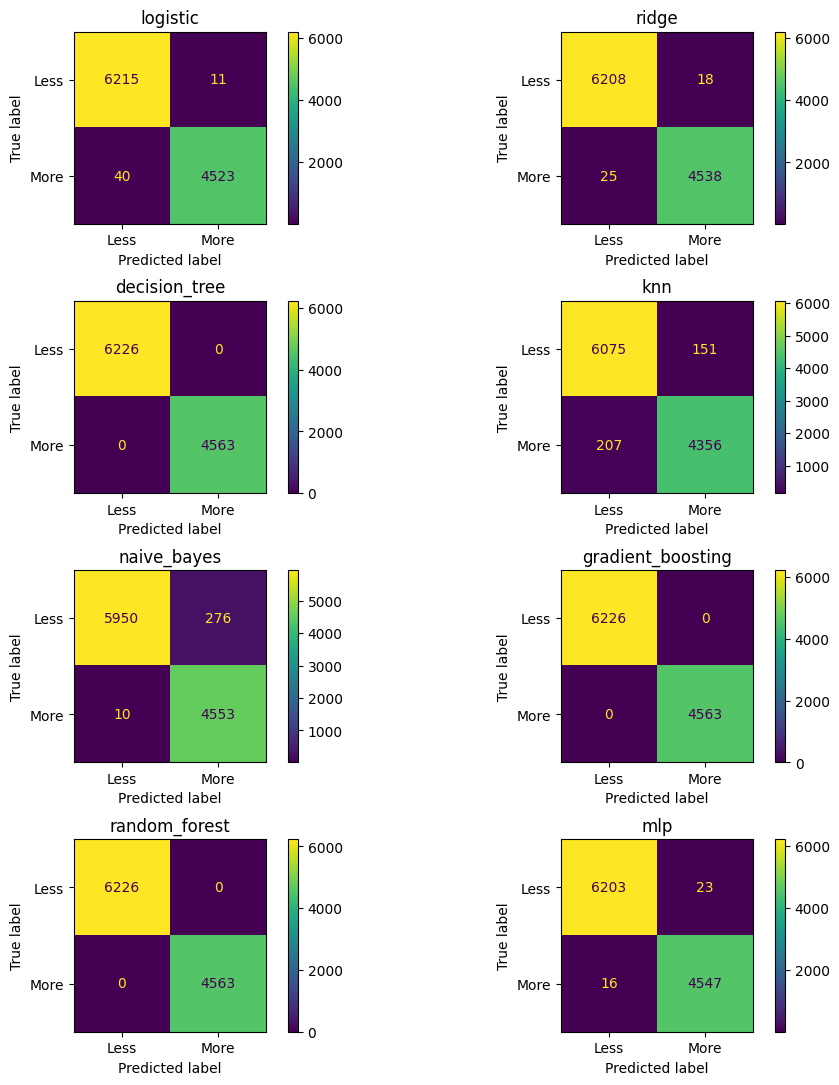

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Функция, создающая фигуру и набор подграфиков (axes)
_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Less", "More"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Точность, полнота, верность (аккуратность), F-мера

In [46]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
#сортировка по столбцу Accuracy_test в порядке убывания
#чтобы увидеть модели с наивысшей точностью на тестовой выборке в начале таблицы
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
).style.background_gradient( #визуализация
    cmap="plasma",
    low=0.3,
    high=1,
    #Указывает, какие столбцы будут окрашены
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [15]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False).style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

In [16]:
#выводим лучшую модель
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

#### Вывод данных с ошибкой предсказания для оценки

In [18]:
#предобработка тестовой выборки
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)
#Получение предсказаний для лучшей модели
y_pred = class_models[best_model]["preds"]

#Определение индексов ошибок
#Сравнивает истинные значения из y_test (столбец above_average_carat) с предсказанными значениями y_pred
#Это дает булев массив, где True означает ошибку
error_index = y_test[y_test["above_average_carat"] != y_pred].index.tolist()
#выводим кол-во ошибок
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df.sort_index()

'Error items count: 0'

Empty DataFrame
Columns: [carat, Predicted, cut, color, clarity, depth, table, price, x, y, z, above_average_carat]
Index: []

#### Пример использования обученной модели (конвейера) для предсказания

In [19]:
model = class_models[best_model]["pipeline"]

example_id = 4500
test = pd.DataFrame(X_test.loc[example_id, :]).T
test_preprocessed = pd.DataFrame(preprocessed_df.loc[example_id, :]).T
display(test)
display(test_preprocessed)
#Получение вероятностей предсказания
result_proba = model.predict_proba(test)[0]
#Получение предсказания
result = model.predict(test)[0]
#Получение реального значения
real = int(y_test.loc[example_id].values[0])
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

carat      cut color clarity depth table price    x     y     z  \
4500   0.9  Premium     H     SI1  61.9  58.0  3629  6.2  6.15  3.82   

     above_average_carat  
4500                   1

x         y  Length_to_Width_Ratio     carat    depth     table  \
4500  0.420272  0.363352               1.156653  0.217442  0.10618  0.245753   

             z  above_average_carat  cut_Good  cut_Ideal  ...  color_I  \
4500  0.399417             1.168162       0.0        0.0  ...      0.0   

      color_J  clarity_IF  clarity_SI1  clarity_SI2  clarity_VS1  clarity_VS2  \
4500      0.0         0.0          1.0          0.0          0.0          0.0   

      clarity_VVS1  clarity_VVS2   price  
4500           0.0           0.0  3629.0  

[1 rows x 26 columns]

'predicted: 1 (proba: [4.39873930e-04 9.99560126e-01])'

'real: 1'

#### Подбор гиперпараметров методом поиска по сетке

In [209]:
from sklearn.model_selection import GridSearchCV

#используем модель случайного леса
optimized_model_type = "random_forest"
random_forest_model = class_models[optimized_model_type]["pipeline"]
#Определение сетки гиперпараметров
param_grid = {
    #Количество деревьев в лесу
    "model__n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
    #Количество столбцов
    "model__max_features": ["sqrt", "log2", 2],
    #Максимальная глубина дерева
    "model__max_depth": [2, 3, 4, 5, 6, 7, 8, 9 ,10],
    #Критерий оценки качества разбиения
    "model__criterion": ["gini", "entropy", "log_loss"],
}
#Указываем модель, которую мы хотим оптимизировать
#Передаем сетку гиперпараметров для поиска
#Указываем, что хотим использовать все доступные процессоры для параллельной обработки
gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
#Метод fit запускает процесс поиска по сетке и обучает модель с различными комбинациями гиперпараметров
#метод ravel() для преобразования меток в одномерный массив
gs_optomizer.fit(X_train, y_train.values.ravel())
#выводим наилучшие значения гиперпараметров
gs_optomizer.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__n_estimators': 20}

Обучение модели с новыми гиперпараметрами

In [210]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=7,
    max_features="sqrt",
    n_estimators=30,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели

In [ ]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

Оценка параметров старой и новой модели

In [212]:
optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=["Accuracy_train", "Accuracy_test", "F1_train", "F1_test"],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
    ],
)

In [213]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
].style.background_gradient(
    cmap="plasma",
    low=0.3,
    high=1,
    subset=[
        "ROC_AUC_test",
        "MCC_test",
        "Cohen_kappa_test",
    ],
).background_gradient(
    cmap="viridis",
    low=1,
    high=0.3,
    subset=[
        "Accuracy_test",
        "F1_test",
    ],
)

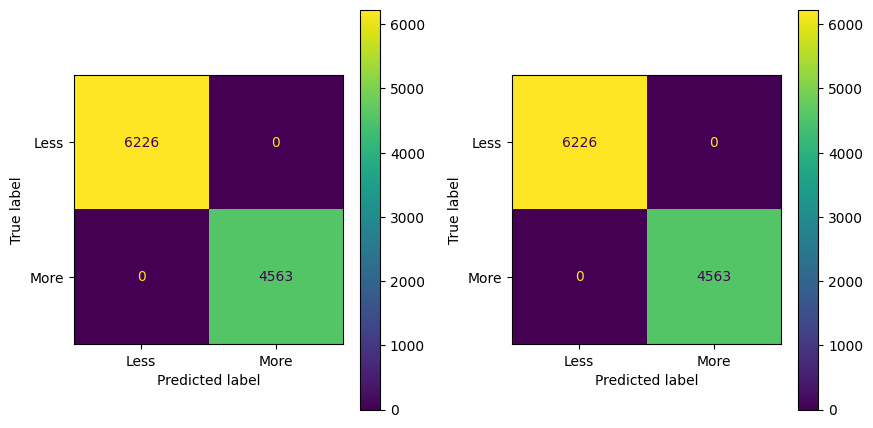

In [215]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False
)

for index in range(0, len(optimized_metrics)):
    c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Less", "More"]
    ).plot(ax=ax.flat[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()